<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Tarea4_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Curso:** Temas Selectos de Física Computacional
# **Conjunto de datos:** Breast Cancer Wisconsin (WDBC)  
# Convención: target=0 -> **Maligno**, target=1 -> **Benigno**.


In [2]:
# Paquetes base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import precision_recall_curve


# 1. Carga de datos y creación de `df` con `target`


In [5]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# 2.Sección 3
# - Histogramas de las primeras 4 columnas
# - Dispersión y KDE

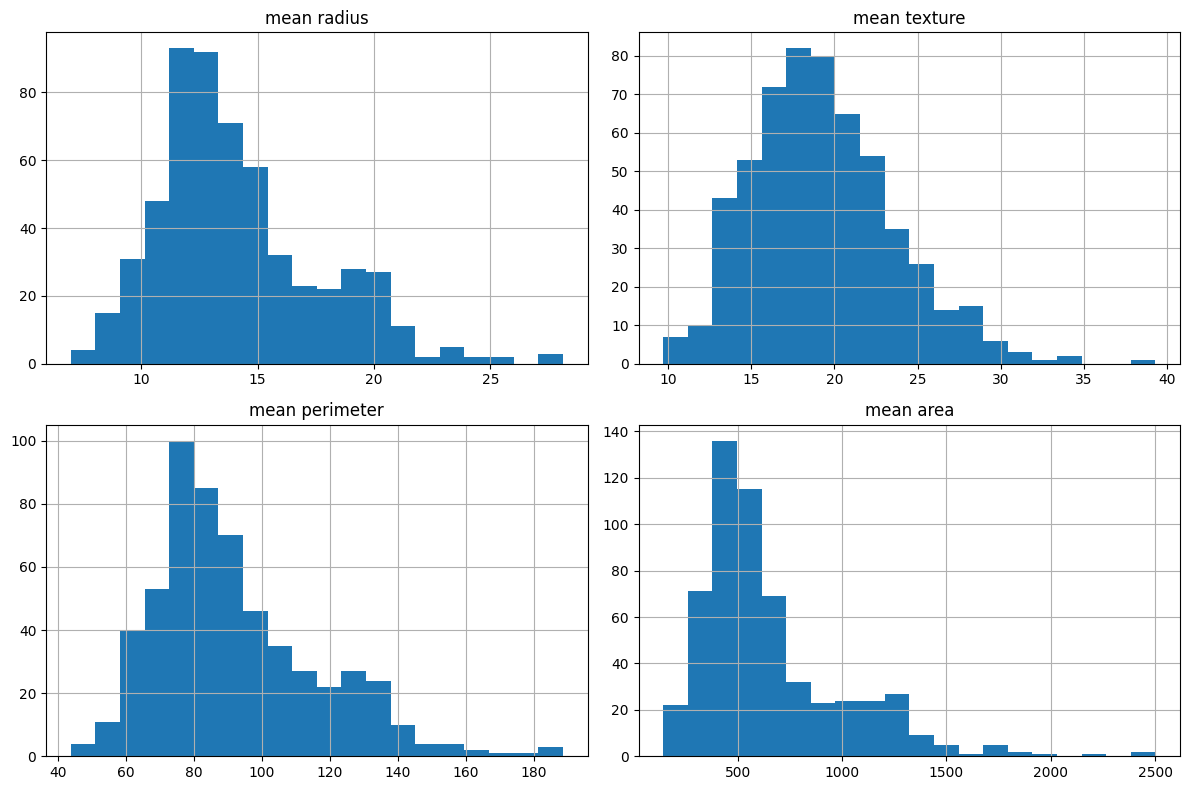

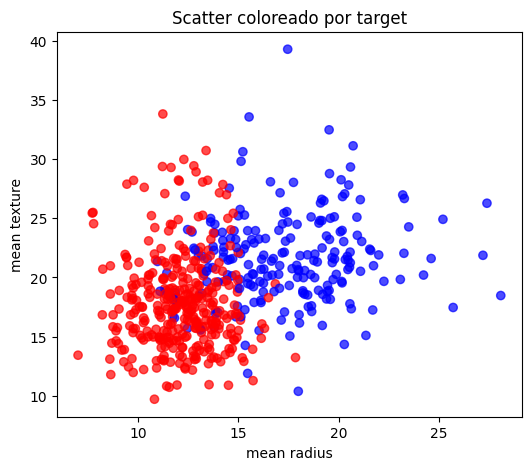

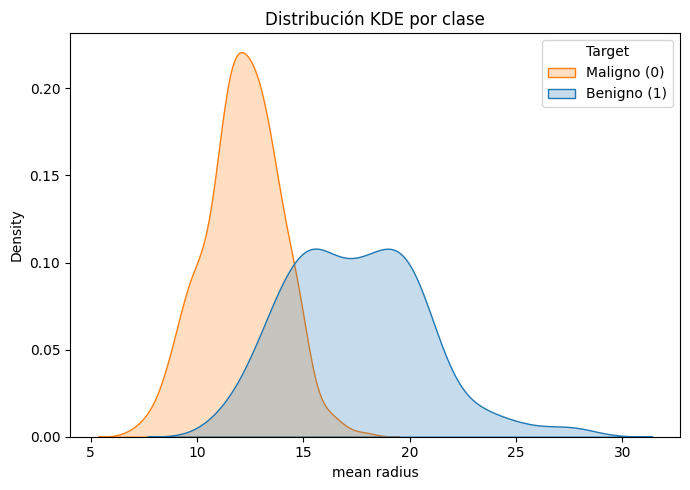

In [7]:
_ = df.iloc[:, :4].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

# Dispersión simple
xvar, yvar = 'mean radius', 'mean texture'
plt.figure(figsize=(6,5))
plt.scatter(df[xvar], df[yvar], c=df['target'], cmap='bwr', alpha=0.7)
plt.xlabel(xvar); plt.ylabel(yvar); plt.title('Scatter coloreado por target')
plt.show()

# KDE por clase para una variable
var = 'mean radius'
plt.figure(figsize=(7,5))
sns.kdeplot(data=df, x=var, hue='target', fill=True, common_norm=False)
plt.xlabel(var); plt.title('Distribución KDE por clase')
plt.legend(title='Target', labels=['Maligno (0)', 'Benigno (1)'])
plt.tight_layout()
plt.show()


# Sección 4
# - Pearson y Spearman
# - Heatmaps y tabla ordenada contra `target`

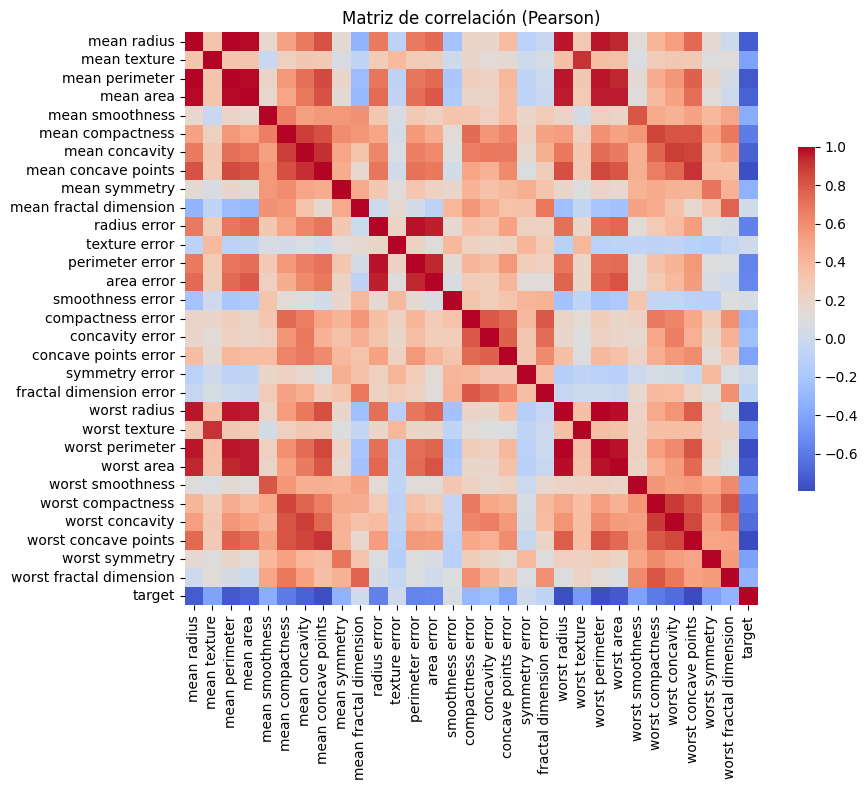

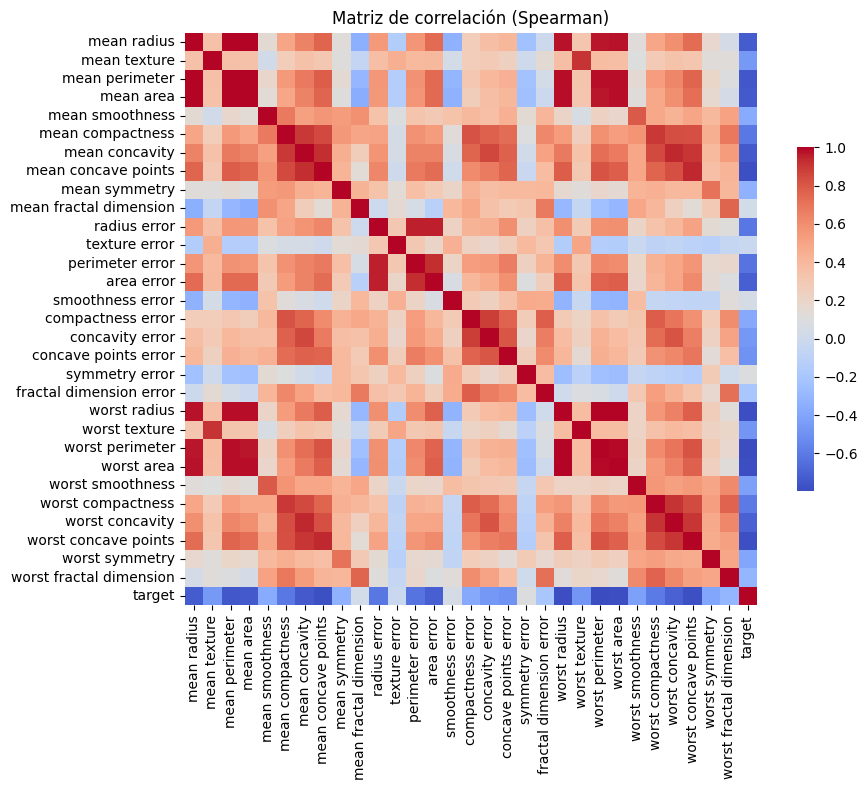

,pearson_wrt_target,abs
worst concave points,-0.793566,0.793566
worst perimeter,-0.782914,0.782914
mean concave points,-0.776614,0.776614
worst radius,-0.776454,0.776454
mean perimeter,-0.742636,0.742636
worst area,-0.733825,0.733825
mean radius,-0.730029,0.730029
mean area,-0.708984,0.708984
mean concavity,-0.696360,0.696360
worst concavity,-0.659610,0.659610


In [8]:
corr_p = df.corr(numeric_only=True) # Pearson
corr_s = df.corr(numeric_only=True, method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(corr_p, cmap='coolwarm', square=True, cbar_kws={'shrink':0.6})
plt.title('Matriz de correlación (Pearson)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(corr_s, cmap='coolwarm', square=True, cbar_kws={'shrink':0.6})
plt.title('Matriz de correlación (Spearman)')
plt.tight_layout(); plt.show()

# Correlación de cada variable con el diagnóstico
target_corr = corr_p['target'].drop('target').to_frame('pearson_wrt_target')
target_corr['abs'] = target_corr['pearson_wrt_target'].abs()
target_corr_sorted = target_corr.sort_values('abs', ascending=False)
target_corr_sorted.head(10)


# Selección automática de 3 variables por nivel de correlación con `target`
# Criterios:
# - ~0 (baja, |corr| < 0.10)
# - moderada (0.30 ≤ |corr| ≤ 0.50)
# - alta (|corr| > 0.75)


In [23]:
import pandas as pd

def to_series(s_or_df, col=None):

    if isinstance(s_or_df, pd.DataFrame):
        if col is None:
            raise ValueError("Pasa 'col' si entregas un DataFrame.")
        return s_or_df[col]
    return s_or_df

def pick_by_abs_corr(target_corr_series,
                     low=(0.0, 0.10),
                     mid=(0.30, 0.50),
                     high=(0.75, 1.0)):

    s = target_corr_series.dropna()
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    dfc = s.to_frame('r').copy()
    dfc['abs'] = dfc['r'].abs()

    def closest_in_range(lo, hi):
        subset = dfc[(dfc['abs'] >= lo) & (dfc['abs'] <= hi)]
        if len(subset) == 0:
            target = (lo + hi) / 2.0
            # índice de la fila cuyo |r| está más cerca del centro del rango
            return dfc.iloc[(dfc['abs'] - target).abs().argsort()].index[0]
        # si hay, toma la de mayor |r| dentro del rango
        return subset.sort_values('abs', ascending=False).index[0]

    v_low  = closest_in_range(*low)
    v_mid  = closest_in_range(*mid)
    v_high = closest_in_range(*high)
    return v_low, v_mid, v_high

# === Uso ===
series_corr = to_series(target_corr, col='pearson_wrt_target')  # si target_corr es DataFrame
v_low, v_mid, v_high = pick_by_abs_corr(series_corr)

print("Baja:", v_low, "| Moderada:", v_mid, "| Alta:", v_high)

# Si prefieres ver también los valores de r:
print({
    'low':  (v_low,  float(series_corr[v_low])),
    'mid':  (v_mid,  float(series_corr[v_mid])),
    'high': (v_high, float(series_corr[v_high])),
})


Baja: fractal dimension error | Moderada: worst texture | Alta: worst concave points
{'low': ('fractal dimension error', -0.07797241739025575), 'mid': ('worst texture', -0.4569028213967986), 'high': ('worst concave points', -0.79356601714127)}


# Descripción estadística y distribuciones

,count,mean,std,min,25%,50%,75%,max
fractal dimension error,569.0,0.003795,0.002646,0.000895,0.002248,0.003187,0.004558,0.02984
worst texture,569.0,25.677223,6.146258,12.020000,21.080000,25.410000,29.720000,49.54000
worst concave points,569.0,0.114606,0.065732,0.000000,0.064930,0.099930,0.161400,0.29100


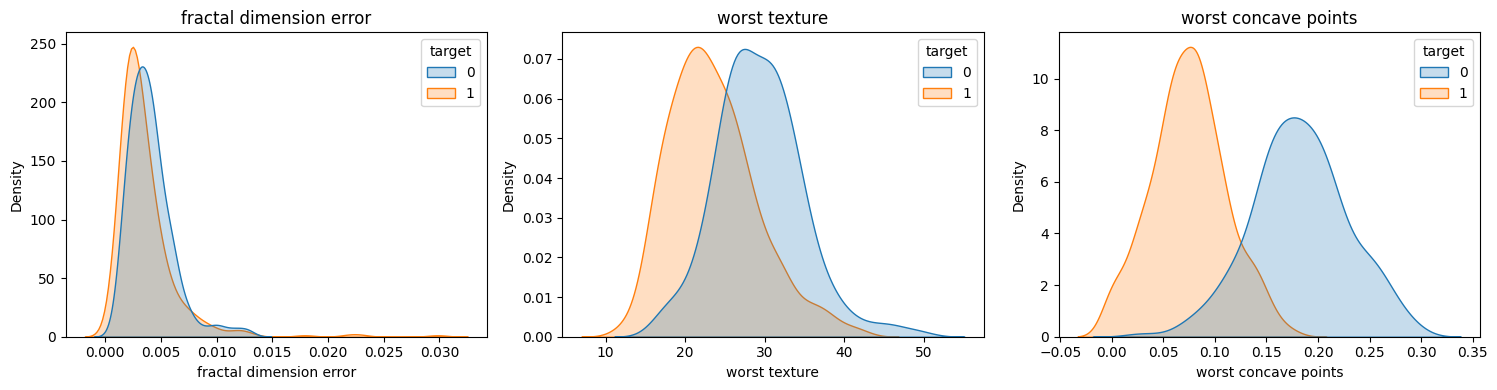

In [13]:
vars_ = [v_low, v_mid, v_high]
desc = df[vars_].describe().T
display(desc)

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, v in zip(axes, vars_):
    sns.kdeplot(data=df, x=v, hue='target', fill=True, common_norm=False, ax=ax)
    ax.set_title(v)
plt.tight_layout(); plt.show()


# Sección 6
# - Si corr(variable, target) > 0 (valores altos -> más probabilidad de **benigno**):
#       valor >= umbral -> predice 1 (benigno), si no -> 0 (maligno).
# - Si corr(variable, target) < 0 (valores altos -> más probabilidad de **maligno**):
#       valor >= umbral -> predice 0 (maligno), si no ->1 (benigno).


In [14]:
def decide_threshold_by_cross(df, var):
    """Heurística: umbral ≈ promedio de medianas por clase (aprox. al cruce de densidades)."""
    m = df[df['target']==0][var].median()  # maligno
    b = df[df['target']==1][var].median()  # benigno
    return (m + b)/2

def predict_by_threshold(series, thr, corr_sign):
    if corr_sign >= 0:   # altos -> benigno
        return (series >= thr).astype(int)
    else:                # altos -> maligno
        return (series <  thr).astype(int)

# Calculamos correlación (signo) y definimos umbrales para cada variable
pred_cols = []
thresholds = {}
for v in vars_:
    r = target_corr.loc[v, 'pearson_wrt_target']  # signo de correlación con target
    thr = decide_threshold_by_cross(df, v)
    thresholds[v] = (thr, r)
    df[f'prediction_{v}'] = predict_by_threshold(df[v], thr, np.sign(r))
    pred_cols.append(f'prediction_{v}')

thresholds, df[pred_cols].head()


({'fractal dimension error': (0.0032737499999999998,
   np.float64(-0.07797241739025575)),
  'worst texture': (25.8825, np.float64(-0.4569028213967986)),
  'worst concave points': (0.128155, np.float64(-0.79356601714127))},
    prediction_fractal dimension error  prediction_worst texture  \
 0                                   0                         1   
 1                                   0                         1   
 2                                   0                         1   
 3                                   0                         0   
 4                                   0                         1   
 
    prediction_worst concave points  
 0                                0  
 1                                0  
 2                                0  
 3                                0  
 4                                0  )

# 6.1 Primeras 30 filas con `target` y predicciones
python
Copiar código


In [15]:
cols_show = ['target'] + vars_ + pred_cols
df.loc[:29, cols_show]


,target,fractal dimension error,worst texture,worst concave points,prediction_fractal dimension error,prediction_worst texture,prediction_worst concave points
0,0,0.006193,17.33,0.26540,0,1,0
1,0,0.003532,23.41,0.18600,0,1,0
2,0,0.004571,25.53,0.24300,0,1,0
3,0,0.009208,26.50,0.25750,0,0,0
4,0,0.005115,16.67,0.16250,0,1,0
5,0,0.005082,23.75,0.17410,0,1,0
6,0,0.002179,27.66,0.19320,1,0,0
7,0,0.005412,28.14,0.15560,0,0,0
8,0,0.003749,30.73,0.20600,0,0,0
9,0,0.010080,40.68,0.22100,0,0,0


# 6.2 FP y FN, conteos y matriz de confusión **manual**
# Definiciones (coherentes con el contexto médico):
# - **TP:** Real maligno(0) y predicho maligno(0) -> NO lo usaremos directamente; trabajaremos con TN/FP/FN/TP explícitos.
# - **FP:** Real 1 (Benigno) pero predicho 0 (Maligno).
# - **FN:** Real 0 (Maligno) pero predicho 1 (Benigno).
# - **TN:** Real 1 y predicho 1.
# - **TP:** Real 0 y predicho 0.

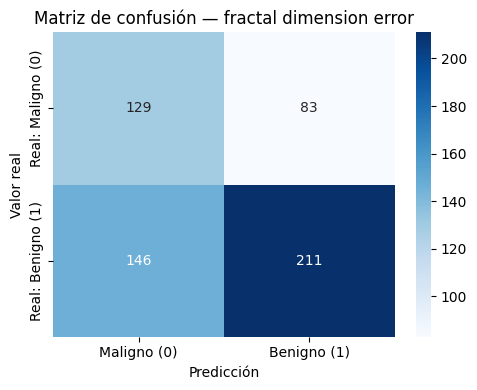

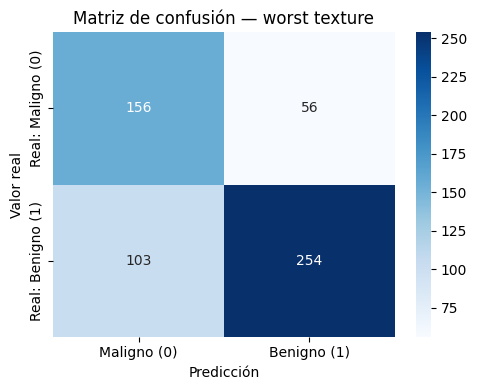

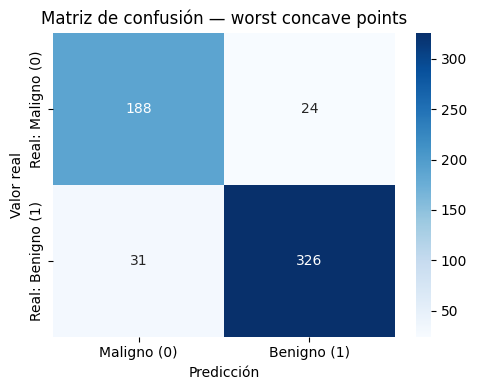

,TP,TN,FP,FN,Accuracy,Precision,Recall,F1
fractal dimension error,129.0,211.0,146.0,83.0,0.597540,0.469091,0.608491,0.529774
worst texture,156.0,254.0,103.0,56.0,0.720562,0.602317,0.735849,0.662420
worst concave points,188.0,326.0,31.0,24.0,0.903339,0.858447,0.886792,0.872390


In [16]:
def confusion_counts(y_true, y_pred):
    TP = np.sum((y_true==0) & (y_pred==0))
    TN = np.sum((y_true==1) & (y_pred==1))
    FP = np.sum((y_true==1) & (y_pred==0))
    FN = np.sum((y_true==0) & (y_pred==1))
    return TP, TN, FP, FN

def metrics_from_counts(TP, TN, FP, FN):
    acc = (TP+TN)/(TP+TN+FP+FN)
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return acc, prec, rec, f1

def show_confusion_heatmap(TP, TN, FP, FN, title='Matriz de confusión (manual)'):
    cm = np.array([[TP, FN],
                   [FP, TN]])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Maligno (0)', 'Benigno (1)'],
                yticklabels=['Real: Maligno (0)', 'Real: Benigno (1)'])
    plt.title(title); plt.xlabel('Predicción'); plt.ylabel('Valor real')
    plt.tight_layout(); plt.show()

results = {}
y_true = df['target'].values
for v in vars_:
    y_pred = df[f'prediction_{v}'].values
    TP, TN, FP, FN = confusion_counts(y_true, y_pred)
    acc, prec, rec, f1 = metrics_from_counts(TP, TN, FP, FN)
    results[v] = dict(TP=TP, TN=TN, FP=FP, FN=FN, Accuracy=acc, Precision=prec, Recall=rec, F1=f1)
    show_confusion_heatmap(TP, TN, FP, FN, title=f'Matriz de confusión — {v}')

pd.DataFrame(results).T


# 7. Barrido de umbral: cómo varían FP y FN
# Para cada variable, barremos umbrales sobre percentiles y graficamos FP/FN.

In [ ]:
def sweep_thresholds(df, var, corr_sign, n=40):
    values = df[var].values
    thrs = np.quantile(values, np.linspace(0.02, 0.98, n))
    FP_list, FN_list = [], []
    for thr in thrs:
        y_pred = predict_by_threshold(df[var], thr, corr_sign).values
        TP, TN, FP, FN = confusion_counts(df['target'].values, y_pred)
        FP_list.append(FP); FN_list.append(FN)
    return thrs, np.array(FP_list), np.array(FN_list)

plt.figure(figsize=(12,4*len(vars_)))
for i, v in enumerate(vars_, 1):
    r = target_corr.loc[v, 'pearson_wrt_target']
    thrs, FPv, FNv = sweep_thresholds(df, v, np.sign(r))
    plt.subplot(len(vars_), 1, i)
    plt.plot(thrs, FPv, label='FP')
    plt.plot(thrs, FNv, label='FN')
    plt.axvline(thresholds[v][0], linestyle='--', label='Umbral elegido')
    plt.title(f'FP y FN vs umbral — {v}')
    plt.xlabel('Umbral'); plt.ylabel('Cantidad'); plt.legend()
plt.tight_layout(); plt.show()


# 8. Curva Precision–Recall


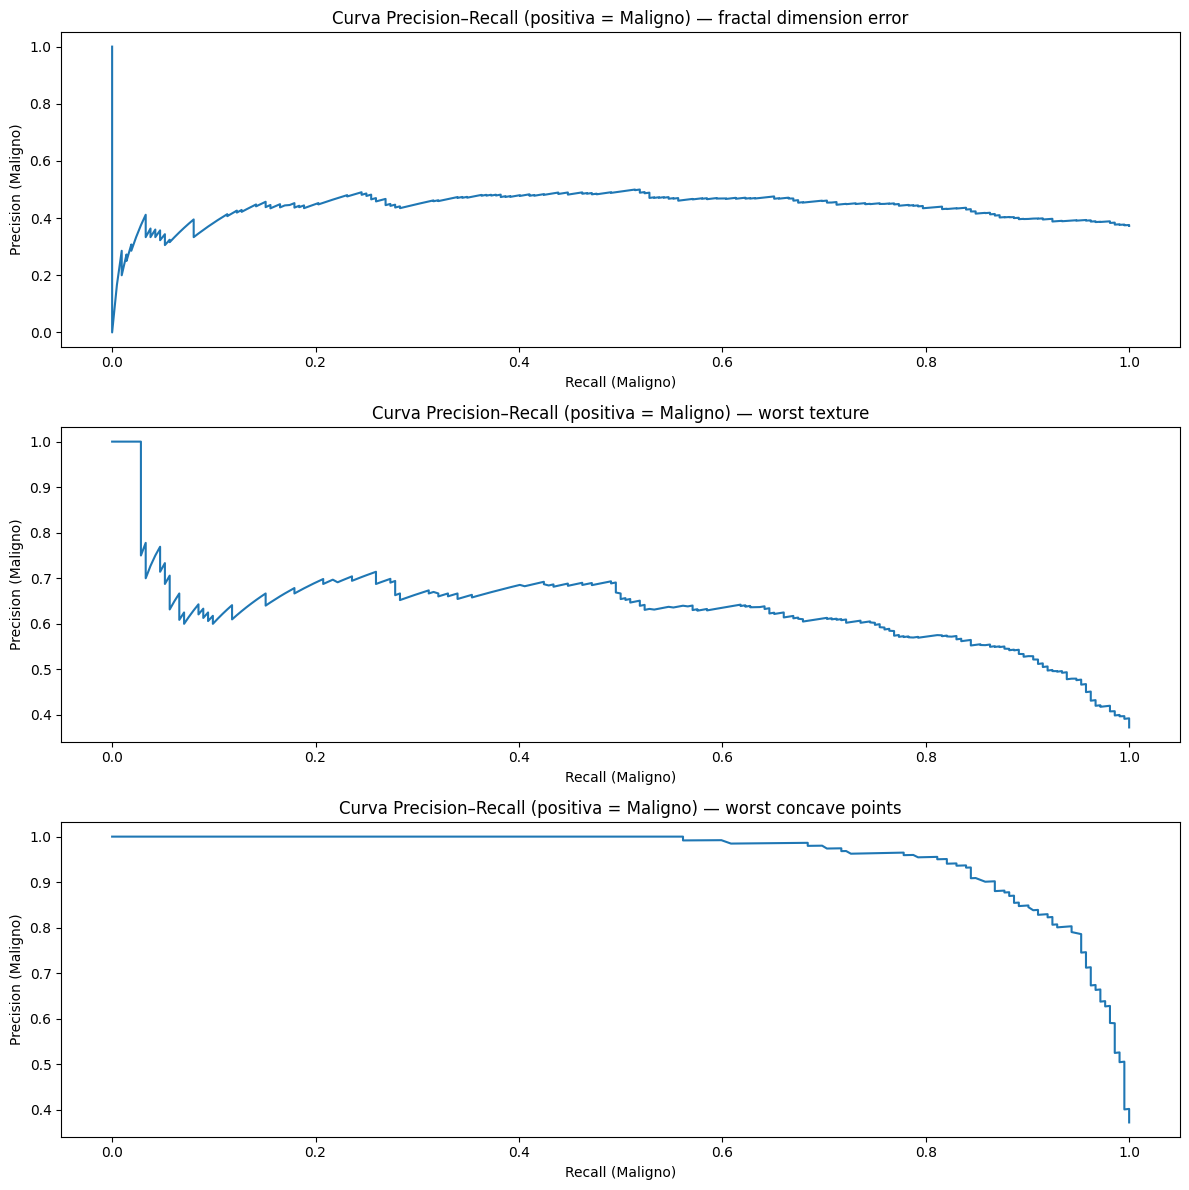

In [17]:
def pr_curve_malignant_positive(df, var, corr_sign):
    true_pos = 1 - df['target'].values  # 1 si maligno
    score = df[var].values if corr_sign < 0 else -df[var].values
    precision, recall, thresholds = precision_recall_curve(true_pos, score)
    return precision, recall, thresholds

plt.figure(figsize=(12,4*len(vars_)))
for i, v in enumerate(vars_, 1):
    r = target_corr.loc[v, 'pearson_wrt_target']
    precision, recall, thresholds = pr_curve_malignant_positive(df, v, np.sign(r))
    plt.subplot(len(vars_), 1, i)
    plt.plot(recall, precision)
    plt.xlabel('Recall (Maligno)'); plt.ylabel('Precision (Maligno)')
    plt.title(f'Curva Precision–Recall (positiva = Maligno) — {v}')
plt.tight_layout(); plt.show()


# 9. Combinación de 2 variables


In [25]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

corr_p = df.corr(numeric_only=True)
target_corr = corr_p['target'].drop('target')

def pick_by_abs_corr(target_corr_series, low=(0.0, 0.10), mid=(0.30, 0.50), high=(0.75, 1.0)):
    dfc = target_corr_series.to_frame('r').copy()
    dfc['abs'] = dfc['r'].abs()
    def closest_in_range(lo, hi):
        subset = dfc[(dfc['abs']>=lo) & (dfc['abs']<=hi)]
        if len(subset)==0:
            target = (lo+hi)/2
            return dfc.iloc[(dfc['abs']-target).abs().argsort()].index[0]
        return subset.sort_values('abs', ascending=False).index[0]
    v_low = closest_in_range(*low)
    v_mid = closest_in_range(*mid)
    v_high = closest_in_range(*high)
    return v_low, v_mid, v_high

v_low, v_mid, v_high = pick_by_abs_corr(target_corr)

def decide_threshold_by_cross(df, var):
    m = df[df['target']==0][var].median()
    b = df[df['target']==1][var].median()
    return (m+b)/2

def predict_by_threshold(series, thr, corr_sign):
    if corr_sign >= 0:
        return (series >= thr).astype(int)
    else:
        return (series < thr).astype(int)

thr_dict = {}
for v in [v_low, v_mid, v_high]:
    r = target_corr.loc[v]
    thr = decide_threshold_by_cross(df, v)
    thr_dict[v] = (thr, r)

def confusion_counts(y_true, y_pred):
    TP = np.sum((y_true==0) & (y_pred==0))
    TN = np.sum((y_true==1) & (y_pred==1))
    FP = np.sum((y_true==1) & (y_pred==0))
    FN = np.sum((y_true==0) & (y_pred==1))
    return TP, TN, FP, FN

def metrics_from_counts(TP, TN, FP, FN):
    acc = (TP+TN)/(TP+TN+FP+FN)
    prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return acc, prec, rec, f1

varA, varB = v_high, v_mid
thrA, rA = thr_dict[varA]
thrB, rB = thr_dict[varB]

predA = predict_by_threshold(df[varA], thrA, np.sign(rA)).values
predB = predict_by_threshold(df[varB], thrB, np.sign(rB)).values

predOR = np.where((predA==0) | (predB==0), 0, 1)

def evaluate(name, y_pred):
    TP, TN, FP, FN = confusion_counts(df['target'].values, y_pred)
    acc, prec, rec, f1 = metrics_from_counts(TP, TN, FP, FN)
    return dict(Modelo=name, TP=TP, TN=TN, FP=FP, FN=FN,
                Accuracy=acc, Precision=prec, Recall=rec, F1=f1)

comp = pd.DataFrame([
    evaluate(f'Solo {varA}', predA),
    evaluate(f'Solo {varB}', predB),
    evaluate(f'OR: {varA} ∨ {varB}', predOR)
])

comp


,Modelo,TP,TN,FP,FN,Accuracy,Precision,Recall,F1
0,Solo worst concave points,188,326,31,24,0.903339,0.858447,0.886792,0.872390
1,Solo worst texture,156,254,103,56,0.720562,0.602317,0.735849,0.662420
2,OR: worst concave points ∨ worst texture,204,230,127,8,0.762742,0.616314,0.962264,0.751381


cols_show = ['target'] + vars_ + pred_cols
df.loc[:29, cols_show]


# 10. Conclusiones
En este análisis se seleccionaron tres variables con diferentes niveles de correlación con el diagnóstico de cáncer de mama: fractal dimension error con correlación baja (r ≈ –0.078), worst texture con correlación moderada (r ≈ –0.457) y worst concave points con correlación alta (r ≈ –0.794). En los tres casos el signo de la correlación fue negativo, lo que indica que valores altos se asocian con mayor probabilidad de malignidad (target = 0). Los umbrales se eligieron como el promedio de las medianas de cada clase, pues este valor coincide aproximadamente con el cruce de las distribuciones KDE y permite separar las regiones donde cambian las probabilidades de pertenencia a cada clase. Al evaluar las matrices de confusión y las métricas de desempeño se observó que fractal dimension error ofrece un rendimiento muy pobre (exactitud ≈ 0.60) y no resulta útil como predictor; worst texture presenta un desempeño intermedio (exactitud ≈ 0.72) con recall aceptable pero precisión baja; mientras que worst concave points destaca por su confiabilidad (exactitud ≈ 0.90, precisión ≈ 0.86, recall ≈ 0.89) y minimiza de forma importante los falsos negativos. El análisis del efecto de variar el umbral mostró que en la variable de baja correlación los falsos positivos y negativos fluctúan sin un patrón claro, en la de correlación moderada se observa un compromiso entre reducir FP y aumentar FN, y en la de alta correlación el balance es más estable y permite ajustar el umbral para reducir FN sin disparar demasiado los FP. Las curvas Precision–Recall confirmaron estas observaciones: fractal dimension error pierde recall rápidamente y su precisión fluctúa, worst texture ofrece un compromiso limitado, mientras que worst concave points mantiene valores altos de precisión y recall en un rango amplio de umbrales, lo que lo convierte en el mejor discriminante. Finalmente, al comparar una sola variable contra la combinación OR de dos, se encontró que el uso exclusivo de worst concave points ofrece buen desempeño, pero al combinarlo con worst texture el número de falsos negativos se redujo drásticamente (de 24 a solo 8), elevando el recall a ≈ 0.96 aunque a costa de más falsos positivos. En un contexto clínico este resultado es más seguro, ya que es preferible aumentar los falsos positivos —que pueden descartarse con pruebas adicionales— antes que pasar por alto un tumor maligno. En conclusión, worst concave points es la variable más confiable individualmente, pero su combinación con otra variable moderada permite alcanzar un recall casi perfecto, priorizando la detección de todos los casos malignos.